# Lab: The Radial Distribution Function for Flying Discs

In this Notebook we analyse movies taken from an 2D analog particle simulator. In this device, small magnetic and repulsive discs move on a flat surface due to air flowing from the sides as well as from underneath to reduce friction (see figure below). The particles are confined by repulsive, magnetic bars, located on the four sides of the square surface.

![alternate text](figs/experiment.png)

## Learning outcomes
- Read and write movies and HDF files from/to disk
- Use image recognition to track particle positions over time
- Analyse molecular _structure_ in solid, liquid, and gaseous phases. Specifically the we investigate the _radial distribution function_, $g(r)$.
- Gain understanding of molecular packing

## Quick guide to Jupyter Notebooks
- Double click on a cell to edit it.
- Execute code in a cell by pressing `shift+return`.
- For getting help on a function, place the cursor inside the `()` brackets and press `shift+tab-tab`.
- More on text formatting, equations etc.
[here](http://jupyter.cs.brynmawr.edu/hub/dblank/public/Jupyter%20Notebook%20Users%20Manual.ipynb).

### Flow of program

1. Split pre-recorded videos into individual images (requires `ffmpeg`)
0. Use image recognition to find particle positions and save to trajectory file (`.h5` format)
0. Calculate distance histogram
0. calculate radial distribution function

More here info about the particle tracker
[here](http://soft-matter.github.io/trackpy/dev/index.html).


In [1]:
# load modules required for the analysis
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
from pandas import DataFrame, Series
import os, pims, scipy, trackpy as tp
import base64
from scipy.spatial import distance
from IPython.display import HTML
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})

# this function is used to visualize videos in the notebook
def video(file, mimetype='mp4'):
    """ Show given video file """
    video_encoded = base64.b64encode( open(file, "r+b").read() )
    return HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(video_encoded.decode('ascii')))

### Movie files
The following three videos of particle simulations were recorded using a smart phone and these will be the basis of the following analysis.
Here we create an array containing the filenames of the movies and two parameters that will be used for the image analysis:

- `diameter`: the diameter of the particles
- `percentile`: minimum relative brightness of the particles to distinguish them from the background 

In [2]:
movies = [
    {'file': 'movies/N20-light.mp4', 'percentile': 60, 'diameter': 53}, # dictionary for movie 0
    {'file': 'movies/N40-light.mp4', 'percentile': 60, 'diameter': 53}, # dictionary for movie 1
    {'file': 'movies/N55-light.mp4', 'percentile': 60, 'diameter': 53}  # dictionary for movie 2
] # more movies can be added as needed...

### Select one of the videos 
Use the indexes from 0 to 2 to select one of the `dictionaries` containing filename, percentile and diameter for a system of N particles.

In [3]:
movie = movies[1]  # select movie file here by index, starting from 0
moviefile = movie['file'] # select key 'file' of the dictionary

Here we visualize the movie.

In [4]:
video(moviefile)

### Split movie into individual files

Here we use the command line tool `ffmpeg` to split the movie into individual images as these are easier for the `trackpy` module to handle.<br>
First we check if the directory `movies` exist–if yes the images have already been generated and we can skip this step. 

In [5]:
imgdir=os.path.splitext(moviefile)[0]
if not os.path.exists(imgdir):
    os.makedirs(imgdir)
    !ffmpeg -i $moviefile -f image2 -vcodec mjpeg $imgdir/img-%03d.jpg -v 0

### Locate particle positions using image recognition 

Before analysing all frames found in the 10-15 sec movie, let's check if the (slow) feature extraction
works for a _single_ frame (*e.g.* the first one, `frames[0]`).

read 498 frames.
             y           x          mass       size       ecc     signal  \
35  539.503302  308.356906  56855.877261  13.418117  0.094563  65.558304   
36  549.258935  399.244428  76412.935987  15.812037  0.045573  67.661779   
37  560.256539  145.113801  72499.420767  15.758626  0.027797  68.012358   
38  560.559701  487.081057  69794.351929  16.115308  0.012760  66.259462   
39  553.710432  230.374570  54767.126595  13.639831  0.069960  64.155987   

       raw_mass   ep  frame  
35 -220283.2828  0.0      0  
36 -169858.7518  0.0      0  
37 -162536.7742  0.0      0  
38 -150592.9570  0.0      0  
39 -212596.9719  0.0      0  


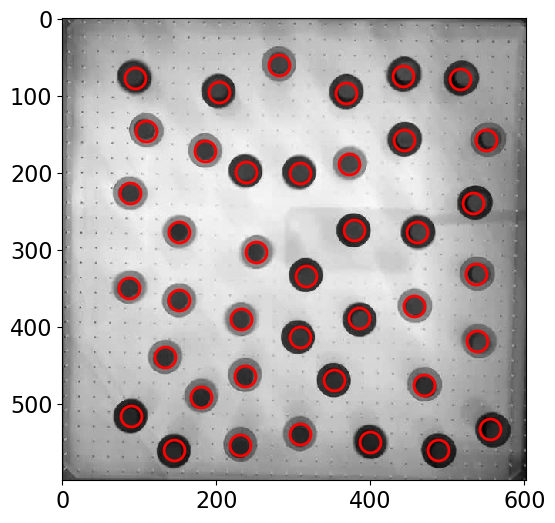

In [6]:
@pims.pipeline
def as_grey(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

color_frames = pims.ImageSequence(imgdir+'/img*.jpg') # load all frames in color
frames = as_grey(color_frames) # convert to grey-scale

print('read',len(frames),'frames.')
f = tp.locate(frames[0], diameter=movie['diameter'], invert=True, percentile=movie['percentile'])
print(f.tail())

# this is how we may separate light and heavy particles
heavy = f[f['mass']>50000] # heavy particles
light = f[f['mass']<50000] # light particles

tp.annotate(f, frames[0])
plt.show()

### Extract particle positions from all frames

Assuming that the recognition settings are OK, let's loop over all frames, extract features, and save to a `.h5` trajectory file.
This process is done *only* if the trajectory file, `trjfile`, does not exist,

_Warning: this is a slow process!_

In [12]:
trjfile=os.path.splitext(moviefile)[0]+'.h5'
if os.path.isfile(trjfile):
    print(f'opening existing trajectory file: {trjfile}')
else:
    with tp.PandasHDFStore(trjfile) as s:
        cnt=0
        for image in frames:
            cnt=cnt+1
            print( 'frame %d/%d.' % (cnt, len(frames)), end=' ')
            features = tp.locate(
                image, diameter=movie['diameter'], percentile=movie['percentile'], invert=True)
            print('number of particles =',len(features))
            s.put(features[['x','y','mass','frame']])

opening existing trajectory file: movies/N40-light.h5


### Read trajectory file and calculate distances between all points

In this section we calculate all distances between all particles for each frame. These are then binned into a histogram to give the probability of observing a particular separation.<br>
At the same time we sample the distribution for _ideal_ particles by simply generating random positions and perform the same analysis as for the "real" particles.

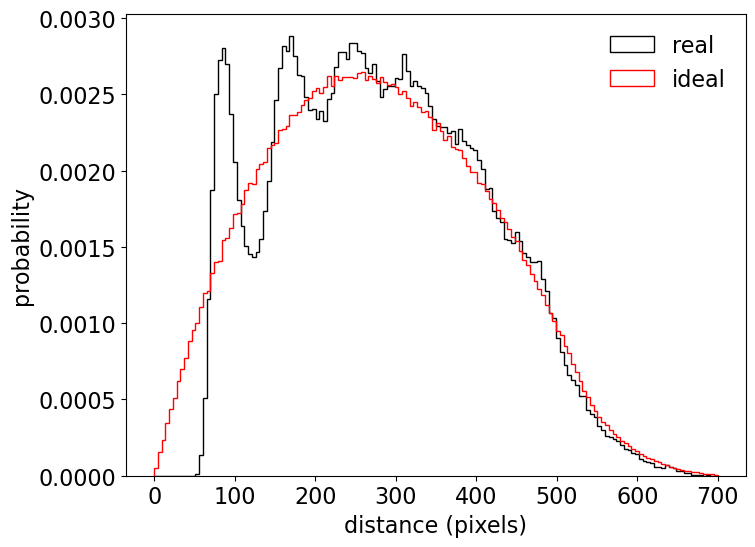

In [14]:
dist  = np.ndarray(shape=(0,0))  # movie distribution
udist = np.ndarray(shape=(0,0))  # uniform distribution

with tp.PandasHDFStore(trjfile) as s:
    # measure all distances between discs
    for frame in s:
        dist = np.append( dist, distance.pdist( frame[['x','y']] ))

    data = s.dump() # keep full trajectory in `data`
    
    # find box corners
    xmin, xmax = min(data.x), max(data.x)
    ymin, ymax = min(data.y), max(data.y)
    
    # measure distances for uniform, random distribution (no correlations)
    # (number of points/particles is unimportant.)
    x     = np.random.randint(xmin, xmax+1, 4000)
    y     = np.random.randint(ymin, ymax+1, 4000)
    p     = np.array([x, y]).T
    udist = np.append( udist, distance.pdist(p) )
        
    hist  = plt.hist(dist,  bins=150, density=True, range=[0,700], histtype='step', color='black', label='real')
    uhist = plt.hist(udist, bins=150, density=True, range=[0,700], histtype='step', color='red', label='ideal')

    plt.legend(loc=0,frameon=False)
    plt.xlabel('distance (pixels)')
    plt.ylabel('probability')
    plt.show()

### Radial Distribution Function, $g(r)$

We have now calculated the distance distribution, `hist`, from the simulated particles from the movie, as well as for a uniform distribution of $N$ particles, `uhist`. The radial distribution function is simply the ratio between the two.
This means that if the particles were behaving ideally (which they don't), $g(r)$ would be unity for all separations, $r$. After plotting, the final rdf is saved to disk.

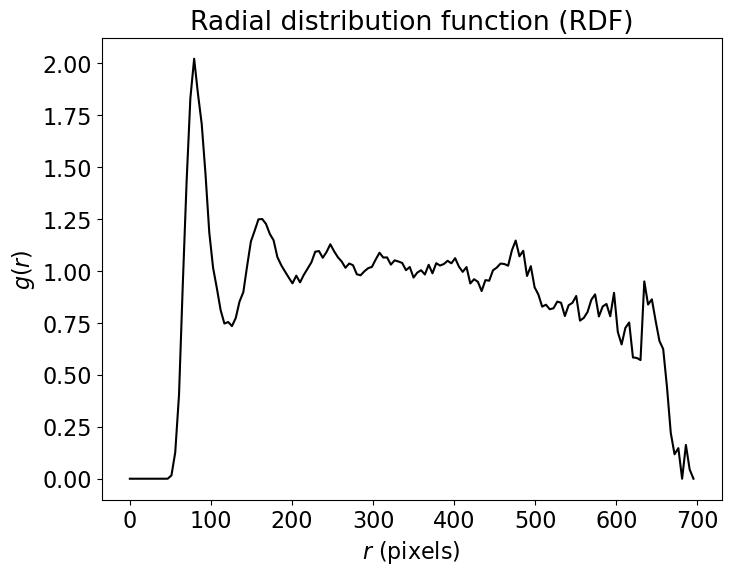

In [9]:
r = hist[1][:len(hist[0])]
g = hist[0] / uhist[0]
plt.plot( r, g, 'k-')
plt.xlabel('$r$ (pixels)')
plt.ylabel('$g(r)$')
plt.title('Radial distribution function (RDF)')

rdffile=os.path.splitext(moviefile)[0]+'.rdf.dat'
np.savetxt(rdffile, np.array([r,g]).T, header='rdf from '+moviefile)

### Plot all rdf's found on disk

(0.0, 4.0)

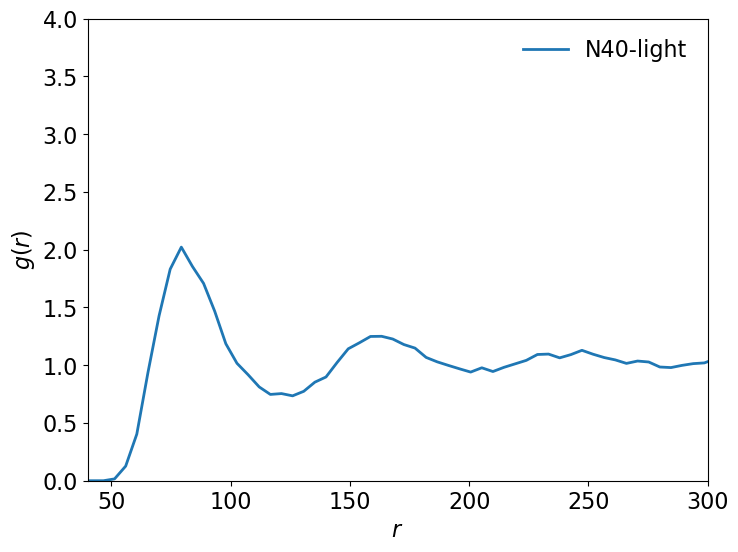

In [15]:
for d in movies:
    name = os.path.splitext(d['file'])[0]
    rdffile = name+'.rdf.dat'
    if os.path.isfile(rdffile):
      r, g = np.loadtxt(rdffile, unpack=True )
      plt.plot(r, g, '-', label=os.path.basename(name), lw=2)
plt.legend(loc=0,frameon=False)
plt.xlabel('$r$')
plt.ylabel('$g(r)$')
plt.xlim([40,300])
plt.ylim([0,4])

### Exercises, Part I
0. Why does $g(r)$ deviate from unity at large separations?
0. What is the particle size and the system's volume fraction (area occupied by the particles / total area)?
0. It seems as if there's a small maximum in $g(r)$ at short separations. Is this real and, if so, how is this possible for repulsive particles?
0. Convert $g(r)$ to the potential of mean force and plot this (Hint: use numpy's function `np.log()` as in `pmf=-np.log(g)`).
0. Repeat the full analysis but for a more concentrated system. Discuss differences.

## Outlook

There's always many more things we can investigate.
In the above we studied structure through $g(r)$ which is a static, equilibrium property that does not depend on time.
In the "experiment", we however have access to kinetics as well and the following code snippet shows how we may track particles over time.
With this we could e.g. calculate the velocity distribution to get an idea of the "temperature" which here is controlled by the airflow.

In [1]:
movie = movies[0]  # select movie file here by index, starting from 0
moviefile = movie['file'] # select key 'file' of the dictionary
trjfile=os.path.splitext(moviefile)[0]+'.h5'
with tp.PandasHDFStore(trjfile) as s:
    data = s.dump() 
t = tp.link_df(data, search_range=20, memory=3)
tp.plot_traj(t)

NameError: name 'movies' is not defined

In [ ]:
for d in movies:
    name = os.path.splitext(d['file'])[0]
    trjfile = name+'.h5'
    with tp.PandasHDFStore(trjfile) as s:
        data = s.dump() 
    t = tp.link_df(data, search_range=20, memory=3)
    em = tp.emsd(t, mpp=20./600., fps=24) # mpp=cm per pixel calculate mean square displacement
    plt.plot(em.index, em, 'o',label=os.path.basename(name))
plt.legend(loc=0,frameon=False)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [cm$^2$]')
plt.xlabel('lag time $t$ [s]')
plt.show()
# plt.savefig('../Fig/name.pdf',format='pdf')